(Note that all units unless otherwise mentioned are SI units.)

In [1]:
import numpy as np
import numexpr as ne
import matplotlib.pyplot as plt
import pickle,os
from multislice import prop,prop_utils

Importing all the required libraries.

In [2]:
def make_zp_from_rings(n,grid_size):
    zp = np.zeros((grid_size,grid_size))
    for i in range(n):
        if i%2 == 1 :
            locs_ = np.load('ring_locs_'+str(i)+'.npy')
            locs_ = tuple((locs_[0],locs_[1]))
            vals_ = np.load('ring_vals_'+str(i)+'.npy')
            zp[locs_] = vals_
    return zp

*make_zp_from_rings* : make a zone plate from the rings which were created earlier.
* *Inputs* : n - number of rings, grid_size 
* *Outputs* : a numpy array containing the zone plate

grid_size  :  5000
step_xy  :  2.800560112021502e-08
energy(in eV)  :  500
wavelength in m  :  2.47968e-09
focal_length  :  0.0015
zp_coords  :  [-7e-05, 7e-05, -7e-05, 7e-05]
delta  :  0.0048625
beta  :  0.004763


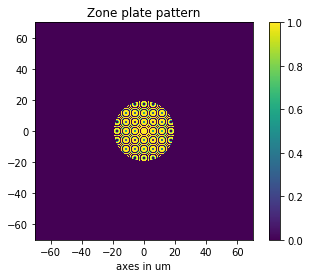

In [3]:
os.chdir(os.getcwd()+str('/rings'))
parameters = pickle.load(open('parameters.pickle','rb'))
for i in parameters : print(i,' : ',parameters[i])
zp_coords = parameters['zp_coords']
grid_size = parameters['grid_size']
zp = make_zp_from_rings(100,int(grid_size))
plt.imshow(zp,extent=np.array(zp_coords)*1e6)
plt.title('Zone plate pattern')
plt.xlabel('axes in um')
plt.colorbar()
plt.show()

Importing zone plate pattern and the parameters associated with it. Plotting the zone plate after creating it from the rings. One needs to save the image with high dpi to clearly see the zone plate. 

In [4]:
beta  = parameters['beta']
delta = parameters['delta']
step_xy = parameters['step_xy']
wavel = parameters['wavelength in m']
f = parameters['focal_length']
L = step_xy*np.shape(zp)[0] 
m,n = np.shape(zp)
zp_thickness = 10e-6

*Setting up the parameters for the simulation*<br>
* *beta and delta*       : delta and beta at the relevant energy <br>
* *step_xy*              : sampling in the xy plane<br>
* *wavel*                : wavelength<br>
* *f*                    : focal length<br>
* *wavefront*            : wavefront that is initialzed with magnitude of 1 and phase of 0<br>
* *L*                    : support length<br>
* *m,n*                  : dimensions of input zp<zp>
* *zp_thickness*         : thickness of zone plate <br>

In [5]:
i = 0 #Angle in degrees
theta = (i)*(np.pi/180)
slope = np.tan(theta)
x = np.linspace(zp_coords[0],zp_coords[1],n)
X,Y = np.meshgrid(x,x)
z1 = 2*np.pi*(1/wavel)*slope*X
del X,Y,x
wave_in = np.multiply(np.ones(np.shape(zp),dtype='complex64'),np.exp(1j*(z1)))
del z1

Creating the input wave for the simulation. The input wave has a position(along one axis) dependent phase to simulate the effect of tilting the zone plate (instead of tilting the zone plate itself though tilting the zone plate might be more efficient in the long run)

In [6]:
np.save('zp.npy',zp)

In [7]:
number_of_steps =  prop_utils.number_of_steps(step_xy,wavel,zp_thickness)*2
ne.set_vml_num_threads(12)
wave_exit,L1 = prop_utils.optic_illumination(wave_in,zp,delta,beta,zp_thickness,
                                              step_xy,wavel,number_of_steps,0,0)
del zp,wave_in

suggested step size : 3.162963342465918e-06
number of steps required for propogation through the zone plate : 5
propogator to be used : Transfer Function
Fresnel Number : 7907408.356164794


Propogation through zone plate...: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


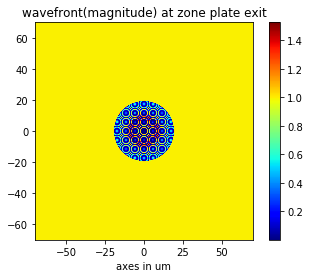

1.5268324629510486


In [8]:
plt.imshow(np.abs(wave_exit),extent=np.array([-L1/2,L1/2,-L1/2,L1/2])*1e6,cmap='jet')
plt.xlabel('axes in um')
plt.title('wavefront(magnitude) at zone plate exit')
plt.colorbar()
plt.show()
print(np.max(np.abs(wave_exit)))

In [9]:
step_z = f
p = prop_utils.decide(step_z,step_xy,L,wavel)
print('Propagation to focal plane')
print('Fresnel Number :',((L**2)/(wavel*step_z)))
wave_focus,L2 = p(wave_exit - np.ones(np.shape(wave_exit)),step_xy,L,wavel,step_z)
wave_focus = wave_focus +  np.ones(np.shape(wave_exit))

propogator to be used : Transfer Function
Propagation to focal plane
Fresnel Number : 5271.605570776531


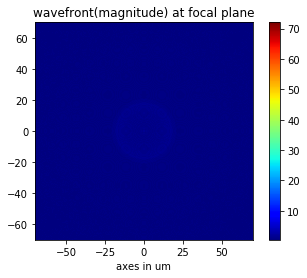

In [10]:
plt.imshow(np.abs(wave_focus),extent=np.array([-L2/2,L2/2,-L2/2,L2/2])*1e6,cmap='jet')
plt.xlabel('axes in um')
plt.title('wavefront(magnitude) at focal plane')
plt.colorbar()
plt.show()

The focal spot size is ~50 pixels and one can't see it when the whole wavefront (40k by 40k) is visualized ! 
Another thing one can notice is the faint outline of a square, this is because the output grid dimensions are different from the input grid dimensions and the length of the side of this square is nothing but the support length of the input plane.

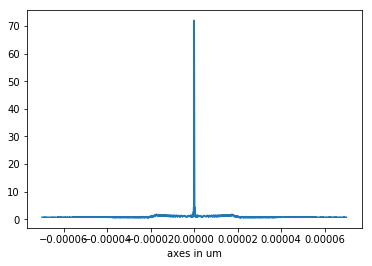

slice in x-direction along the focal plane


In [11]:
x = np.linspace(-1,1,grid_size)*L2/2
plt.plot(x,abs(wave_focus)[int(grid_size/2),:])
plt.xlabel('axes in um')
plt.show()
print('slice in x-direction along the focal plane')

The above plot shows that the location of the focal spot has shifted due to the tilt of the input wave.

In [12]:
focal_spot_size = 100
focal_spot,x_,y_,max_val = prop_utils.get_focal_spot(np.abs(wave_focus),grid_size,focal_spot_size)

max_loc : 2499 2500 100 100


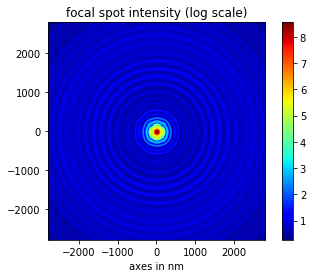

In [13]:
plt.imshow(np.log(focal_spot**2+1),extent = np.array([-1,1,-1,1])*(focal_spot_size)*(L2/grid_size)*(1e9),cmap='jet')
plt.title('focal spot intensity (log scale)')
plt.xlabel('axes in nm')
plt.colorbar()
plt.show()